In [1]:
%load_ext autoreload
%autoreload 2
%run ~/FKMC/notebooks/notebook_preamble.py
%matplotlib inline

columnwidth = 246/72.27 * 2
plt.style.use('../custom.mplstyle')
#from customcolors import colors, colors10, custom_cmap

np.seterr(under = 'ignore')

data_location = Path('~/HPC_data/pickled_data').expanduser()
figure_location = Path('~/git/Late-Stage-Review/figs').expanduser()

width = columnwidth
height =  columnwidth / 2

Imported pathlib::Path, os, munch::Munch, pickle, logging, itertools::count, matplotlib::colors
Names are pyplot = plt, matplotlib = mpl, numpy = np


In [150]:
%%time
from FKMC.montecarlo import FK_mcmc, perturbation_accept, p_multi_site_uniform_reflect, p_one, p_two, p_one_or_two

initial_states = Munch(
    CDW1 = lambda N: np.arange(N, dtype = np.float64) % 2,
    CDW2 = lambda N: (np.arange(N, dtype = np.float64)+1) % 2,
    zeros = lambda N: np.zeros(N, dtype = np.float64),
    ones = lambda N: np.ones(N, dtype = np.float64),
)

Ham_params = Munch(
    t = 1,
    alpha = 1.25,
    mu = 0,
    beta = 1/3,
    J = 5,
    U = 5,
    normalise = True,
)

N = 100
MCMC_params = Munch(
        state = initial_states.CDW1(N),
        N_steps = 10_000,
        N_burn_in = 0,
        thin = 1,
        proposal = p_one,
        accept_function = perturbation_accept,
        warnings = False,
        raw_steps = True,
)
steps = np.arange(MCMC_params.N_steps)
size = np.arange(N)

o = FK_mcmc(**MCMC_params, parameters = Ham_params)

N = 100: 0% through after 0.00m             acceptance rates: classical = 0% quantum = 0% overall = 0%
N = 100: 10% through after 0.02m             acceptance rates: classical = 65% quantum = 61% overall = 40%
N = 100: 20% through after 0.04m             acceptance rates: classical = 69% quantum = 61% overall = 42%
N = 100: 30% through after 0.05m             acceptance rates: classical = 69% quantum = 61% overall = 42%
N = 100: 40% through after 0.07m             acceptance rates: classical = 70% quantum = 61% overall = 42%
N = 100: 50% through after 0.09m             acceptance rates: classical = 70% quantum = 62% overall = 43%
N = 100: 60% through after 0.11m             acceptance rates: classical = 71% quantum = 61% overall = 43%
N = 100: 70% through after 0.13m             acceptance rates: classical = 70% quantum = 61% overall = 43%
N = 100: 80% through after 0.15m             acceptance rates: classical = 70% quantum = 61% overall = 43%
N = 100: 90% through after 0.17m         

[Text(0.5, 0, 'MCMC Step')]

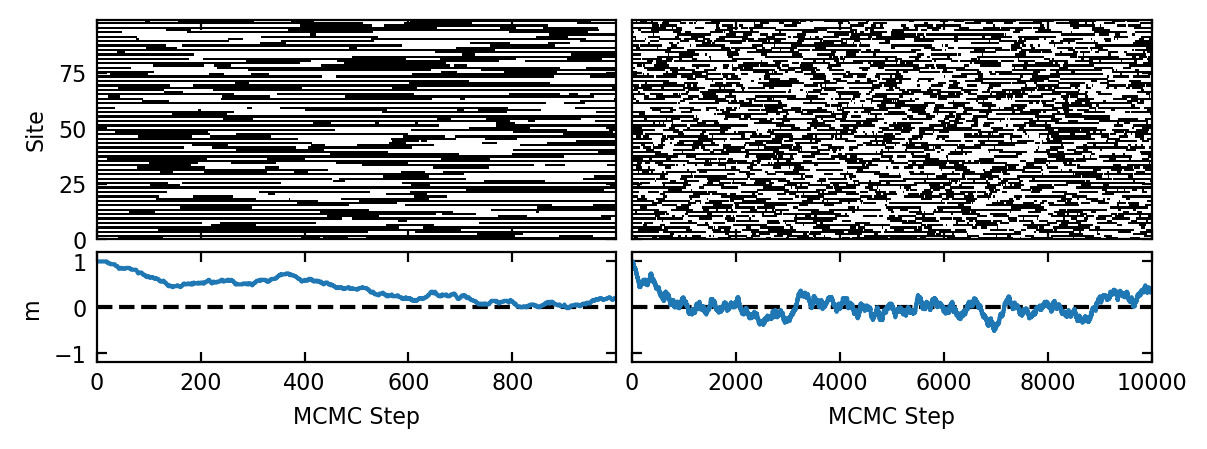

In [181]:
A = (2*(np.arange(N) % 2) - 1)[None, :] * np.ones(o.N_steps)[:, None]

f, cols = plt.subplots(nrows = 2, ncols = 2, figsize = (columnwidth, columnwidth/3), 
                       sharey = 'row',
                       sharex = 'col',
                       gridspec_kw = dict(hspace = 0.08, wspace = 0.03, 
                                          height_ratios = (2,1,)))

for (state_ax, m_ax), xlim in zip(cols.T, [[0, 1000], [0, MCMC_params.N_steps]]):
    state_ax.pcolormesh(steps, size, o.state.T, vmin = 0, vmax = 1, cmap = "Greys", rasterized = True)

    m = 2*(o.state * A).mean(axis = 1)
    m_ax.plot(steps, m)
    m_ax.set(ylim = (-1.2, 1.2), xlim = xlim)
    m_ax.hlines(y = 0, xmin = 0, xmax = MCMC_params.N_steps, linestyle = '--')
    
cols[0,0].set(ylabel = "Site")
cols[1,0].set(ylabel = "m", xlabel = 'MCMC Step', xticks = [0, 200, 400, 600, 800])
cols[1,1].set(xlabel = 'MCMC Step')

In [182]:
f.savefig(figure_location / 'raw_steps_single_flip.eps', bbox_inches='tight')

N = 90


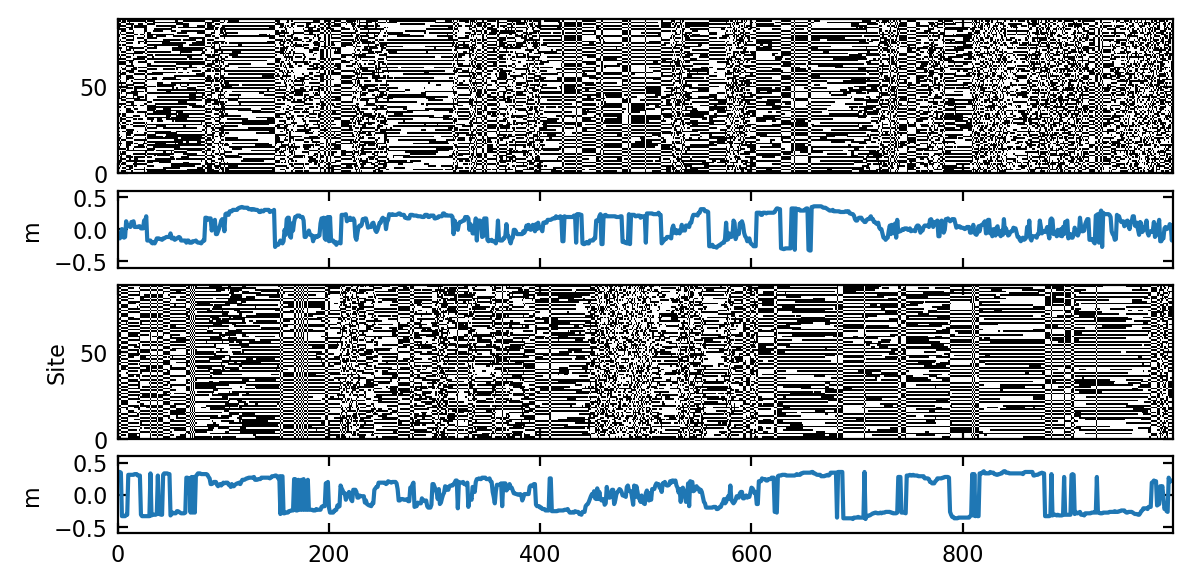

In [72]:
with open(Path('~/HPC_data/pickled_data/1_single_small_system.pickle').expanduser(), 'rb') as file:
    o = pickle.load(file)

N_i = 2
N = o.Ns[N_i]
print(f'N = {N}')
R_i = 0
steps = np.arange(o.N_steps)
size = np.arange(N)
A = (2*(np.arange(N) % 2) - 1)[None, :] * np.ones(o.N_steps)[:, None]

f, (ax, ax2, ax3, ax4) = plt.subplots(nrows = 4, figsize = (columnwidth, columnwidth/2), sharex = 'all', gridspec_kw = dict(hspace = 0.15, height_ratios = (2,1,2,1)))

ax.pcolormesh(steps, size, o.state[N_i][0].T, vmin = 0, vmax = 1, cmap = "Greys", rasterized = True)
ax3.set(ylabel = "Site")

m = (o.state[N_i][0] * A).mean(axis = 1)
ax2.plot(steps, m)
ax2.set(ylabel = "m", ylim = (-.6, .6))

ax3.pcolormesh(steps, size, o.state[N_i][1].T, vmin = 0, vmax = 1, cmap = "Greys", rasterized = True)
ax3.set(ylabel = "Site")

m = (o.state[N_i][1] * A).mean(axis = 1)
ax4.plot(steps, m)
ax4.set(ylabel = "m", ylim = (-.6, .6))

f.savefig(figure_location / 'single.eps', bbox_inches='tight')

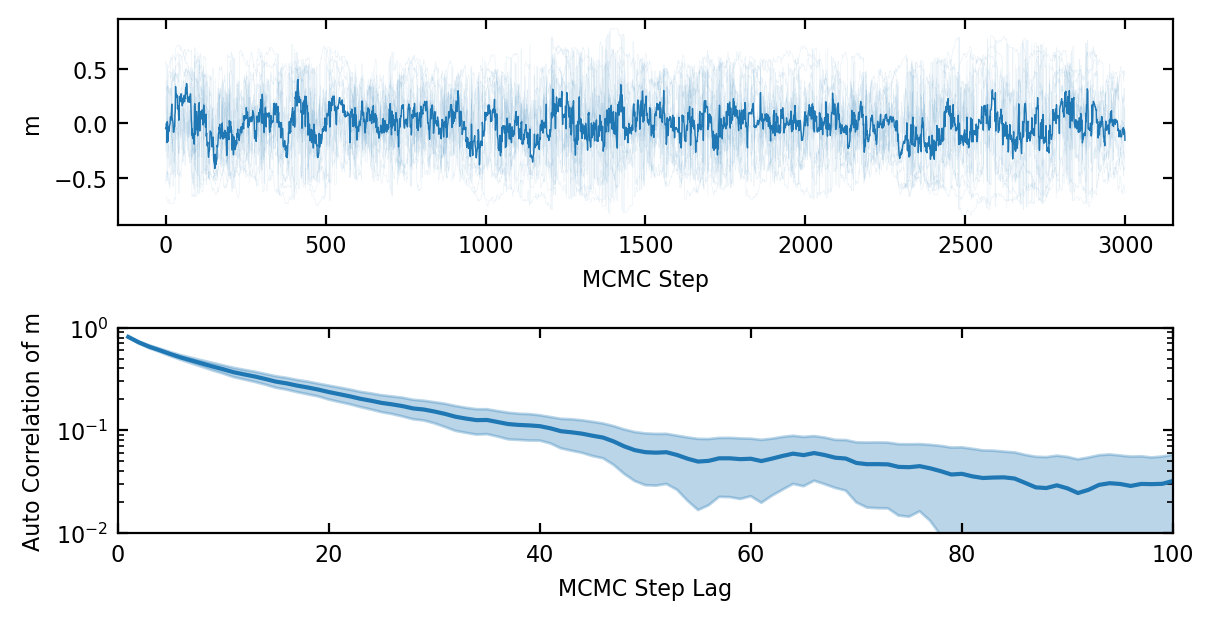

In [320]:
from FKMC.stats import autocorrelation
from scipy.stats import sem
from FKMC.plotting import spread

with open(Path('~/HPC_data/pickled_data/2_correlations.pickle').expanduser(), 'rb') as file:
    o = pickle.load(file)
    
N = o.Ns[0]
steps = np.arange(o.N_steps * 3)
size = np.arange(N)
A = (2*(np.arange(N) % 2) - 1)[None, :]
m = 2*(o.state[0] * A[None, :]).mean(axis = (-1))
n = 2*(o.state[0]).mean(axis = (-1))

f, (ax, ax2) = plt.subplots(nrows = 2, figsize = (columnwidth, columnwidth/2), gridspec_kw = dict(hspace = 0.5))

for obs in [m]:
    auto_correlations = np.array([autocorrelation(a) for a in obs])
    a = auto_correlations.mean(axis = 0)
    da = sem(auto_correlations, axis = 0)
    
    mean, = ax.plot(steps, obs.mean(axis = 0), linewidth = 0.5)
    
    for l in obs:
        ax.plot(steps, l, alpha = 0.1, color = mean.get_color(), linewidth = 0.2)
    spread(ax2, X = np.arange(1,len(a)+1), Y = a, dY = da)
    
ax2.set(xlim = (0,100), ylim = (1e-2, 1), yscale = 'log', ylabel = "Auto Correlation of m", xlabel = 'MCMC Step Lag')
ax.set(ylabel = "m", xlabel = 'MCMC Step')
ax.set_rasterized(True)
ax2.set_rasterized(True)
f.savefig(figure_location / 'm_autocorr.png', bbox_inches='tight')

## Spin Spin correlations

In [105]:
from FKMC.stats import spin_spin_correlation

with open(Path('~/HPC_data/pickled_data/gap_opening.pickle').expanduser(), 'rb') as file:
    o = pickle.load(file)
    
o.hints.keys()

dict_keys(['Mf_moments', 'DOS', 'IPR', 'dDOS', 'dIPR', 'time', 'accept_rates', 'proposal_rates'])

In [108]:
a = np.ones([2,3])
b = np.ones([2,3])
a.shape == b.shape

True

[None, None, (1, 46)]

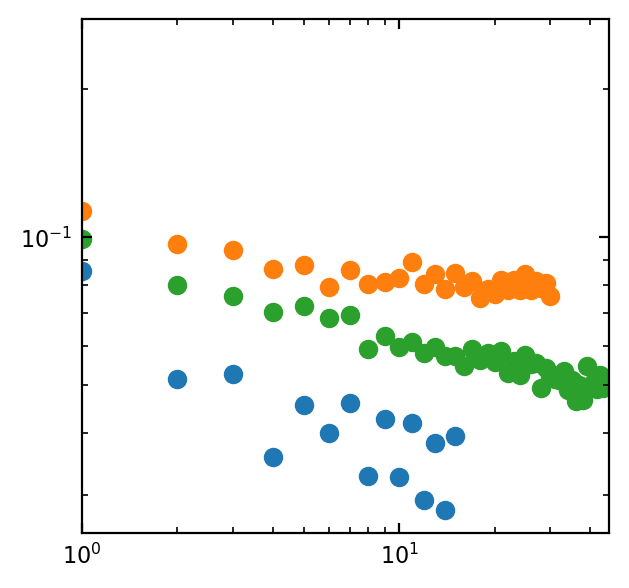

In [99]:
f, ax = plt.subplots()

for N_i, N in enumerate(o.Ns):
    c = spin_spin_correlation(o.state[N_i][1]).mean(axis = 0) * A[0, :N//2 + 1] * -1
    ax.scatter(x = np.arange(c.shape[0]), y = c, label = f'N = {N}')
    
ax.set(xlim = (1,46), yscale = 'log', xscale = 'log')

## Autcorrelations of m for different proposals

In [272]:
from FKMC.stats import spin_spin_correlation

with open(Path('~/HPC_data/pickled_data/3_different_update_steps.pickle').expanduser(), 'rb') as file:
    o = pickle.load(file)
    
o.hints.keys(), o.keys()

(dict_keys(['Mf_moments', 'DOS', 'IPR', 'dDOS', 'dIPR', 'state', 'time', 'accept_rates', 'proposal_rates']),
 dict_keys(['flat', 'hints', 'processed_task_ids', 'this_run', 'datapath', 'codepath', 'py_script', 'batch_params', 'structure_names', 'structure_dims', 'N_tasks', 'chains', 'N_chains', 'original_N_steps', 'thin', 'N_steps', 'max_MC_step', 'E_bins', 'Ns', 'parameters', 'MCMC_params', 'structure_dimensions', 'Algo_names', 'Algos', 'chain_id', 'task_id', 'allow_pickle', 'desc', 'Algo_is', 'Rs', 'Ts', 'Mf_moments', 'DOS', 'IPR', 'dDOS', 'dIPR', 'state', 'time', 'accept_rates', 'proposal_rates', 'm', 'c', 'dm', 'dc']))

In [280]:
o.hints.state, o.state[0].shape, o.Algo_names, o.Ns, o.Ts

(('[Ns]', 'Algo_is', 'Rs', 'Ts', 'MCMC_step', 'N'),
 (6, 5, 3, 3000, 150),
 array(['p_one', 'p_two', 'p_one_or_two', 'p_one_to_N',
        'p_uncorrelated_proposal', 'p_poisson'], dtype='<U23'),
 array([150]),
 [0.6, 1.5, 2.5])

In [304]:
o.time.shape, o.hints.time

((1, 6, 5, 3), ('Ns', 'Algo_is', 'Rs', 'Ts', 'MCMC_step'))

(5, 3000)
(5, 3000)
(5, 3000)
(5, 3000)
(5, 3000)
(5, 3000)
(5, 3000)
(5, 3000)


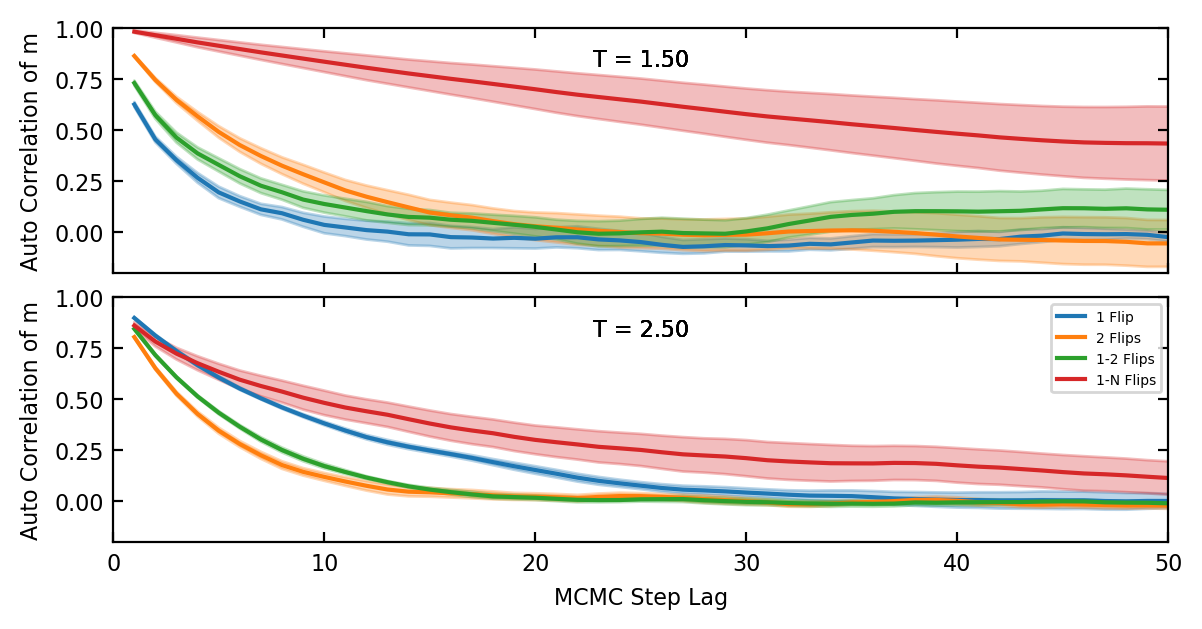

In [323]:
from FKMC.stats import autocorrelation
from scipy.stats import sem
from FKMC.plotting import spread

with open(Path('~/HPC_data/pickled_data/3_different_update_steps.pickle').expanduser(), 'rb') as file:
    o = pickle.load(file)
    
Algo_names = ['1 Flip', '2 Flips', '1-2 Flips', '1-N Flips','Random', 'Poisson']    

N_i = 0
T_i = 2
N = o.Ns[N_i]
steps = np.arange(o.N_steps * 3)
size = np.arange(N)
A = (2*(np.arange(N) % 2) - 1)
m = 2*(o.state[0] * A[None, None, None, None, :]).mean(axis = (-1))
n = 2*(o.state[0]).mean(axis = (-1))

f, axes = plt.subplots(nrows = 2, figsize = (columnwidth, columnwidth/2), gridspec_kw = dict(hspace = 0.1), sharex = 'col', sharey = 'col')

for T_i, ax in zip([1,2], axes):
    for i, name in zip(count(), Algo_names):
        ax.text(25, 0.9, f"T = {o.Ts[T_i]:.2f}", fontsize = 8, ha = 'center', va = 'top')
        if name == 'Random': break
        obs = m[i, :, T_i]
        print(obs.shape)

        auto_correlations = np.array([autocorrelation(a) for a in obs])
        a = auto_correlations.mean(axis = 0)
        da = sem(auto_correlations, axis = 0)

        spread(ax, X = np.arange(1,len(a)+1), Y = a, dY = da, label = name)

axes[1].legend(fontsize = 5)
for ax in axes: ax.set(
    xlim = (0,50),
#     ylim = (1e-2, 1),
    ylim = (-0.2,1),
#    yscale = 'log',
    ylabel = "Auto Correlation of m",)
    
axes[1].set(xlabel = 'MCMC Step Lag')
f.savefig(figure_location / 'autocorr_multiple_proposals.png', bbox_inches='tight')

In [324]:
%%script bash
cd ~/git/Late-Stage-Review
chmod +x ./figs/convert_and_crop.sh
./figs/convert_and_crop.sh
git add figs/*
git add pdf_figs/*.pdf
git status
git commit -m 'automated figure push'
git pull
git push

Converting ./autocorr_multiple_proposals.eps to ../pdf_figs/autocorr_multiple_proposals.pdf
Cropping it
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../pdf_figs/autocorr_multiple_proposals.pdf'.
Converting ./direct_partition_function.eps to ../pdf_figs/direct_partition_function.pdf
Cropping it
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../pdf_figs/direct_partition_function.pdf'.
Converting ./m_autocorr.eps to ../pdf_figs/m_autocorr.pdf
Cropping it
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../pdf_figs/m_autocorr.pdf'.
Converting ./mcmc_partition_function.eps to ../pdf_figs/mcmc_partition_function.pdf
Cropping it
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../pdf_figs

From github.com:TomHodson/Late-Stage-Review
   cca73b2..17ce9ca  main       -> origin/main
To github.com:TomHodson/Late-Stage-Review.git
   17ce9ca..e54e5ad  main -> main
